___
---

## Project Summary

### Objective

I undertook a kitchenware image classification project independently, leveraging a dataset from a past competition hosted by DataTalks.Club. The goal was to develop a robust image classification model capable of identifying various kitchenware items, including cups, glasses, plates, spoons, forks, and knives.

### Competition Overview

The competition, which had already concluded, provided a structured framework for evaluating the performance of image classification models. It featured a diverse dataset collected using Toloka, with additional contributions shared by participants. The evaluation metric used was classification accuracy.

### Personal Goals

My objectives for the project included honing my machine learning skills, gaining practical experience in image classification, and exploring the challenges associated with making machine learning models production-ready.

### Methodology

I followed a systematic approach, including data preprocessing, model development using Keras, and fine-tuning to achieve optimal performance. I also explored additional kitchenware images contributed by participants, augmenting the main competition dataset to enhance model training.

### Results and Achievements

While the competition has concluded, my focus extended beyond achieving a high classification accuracy. I aimed to create a production-ready solution, considering factors such as model interpretability, scalability, and deployment ease.

### Learnings and Challenges

Throughout the project, I encountered and addressed various challenges, refining my understanding of image classification, model optimization, and the transition from a prototype to a production-ready solution. The experience provided valuable insights into real-world machine learning applications.

In [44]:
!ls

best_model.h5  best_model_xception.keras  submission_xception.csv


In [45]:
!ls /kaggle/input/kitchenware-classification/

images	sample_submission.csv  test.csv  train.csv


In [46]:
!ls /kaggle/input/kitchenware-classification/images | head -n 10

0000.jpg
0001.jpg
0002.jpg
0003.jpg
0004.jpg
0005.jpg
0006.jpg
0007.jpg
0008.jpg
0009.jpg
ls: write error: Broken pipe


In [47]:
import pandas as pd

pd.read_csv('/kaggle/input/kitchenware-classification/train.csv')

,Id,label
0,560,glass
1,4675,cup
2,875,glass
3,4436,spoon
4,8265,plate
...,...,...
5554,6742,cup
5555,1574,cup
5556,6746,knife
5557,3562,cup


In [48]:
pd.read_csv('/kaggle/input/kitchenware-classification/test.csv')

,Id
0,678
1,3962
2,9271
3,5133
4,8842
...,...
3803,7626
3804,2052
3805,8827
3806,2299


In [49]:
pd.read_csv('/kaggle/input/kitchenware-classification/sample_submission.csv')

,Id,label
0,678,spoon
1,3962,glass
2,9271,spoon
3,5133,plate
4,8842,spoon
...,...,...
3803,7626,spoon
3804,2052,cup
3805,8827,glass
3806,2299,knife


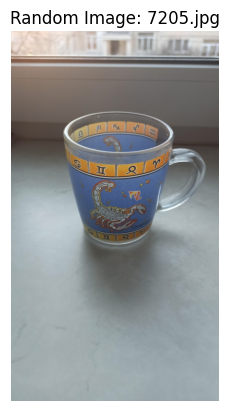

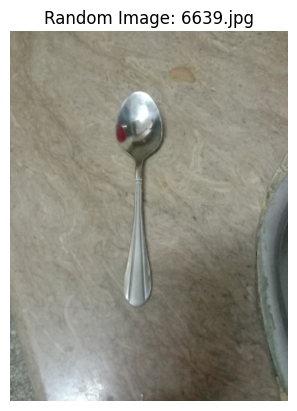

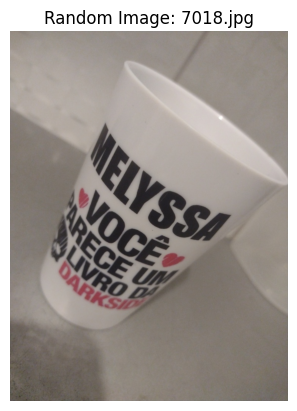

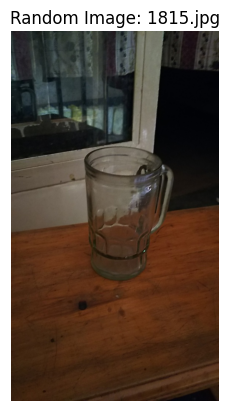

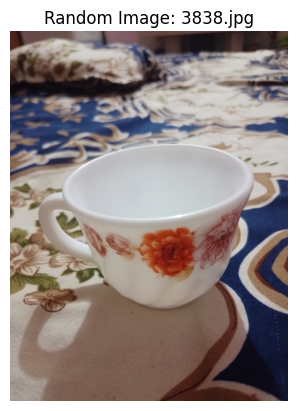

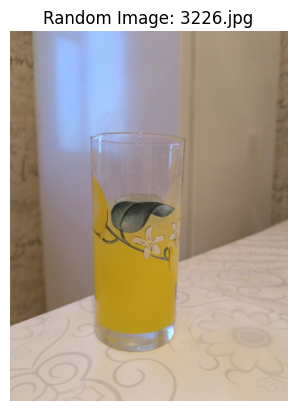

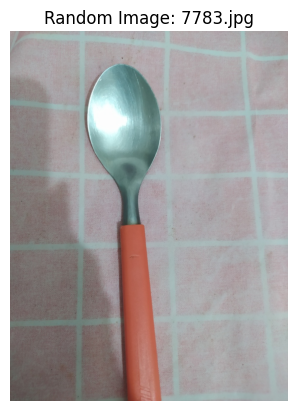

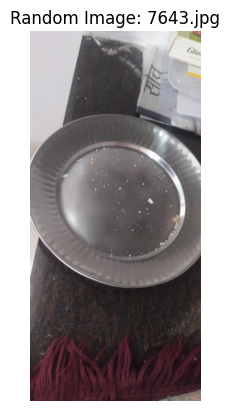

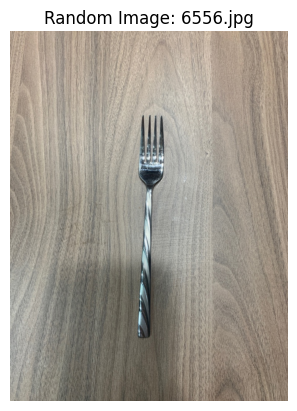

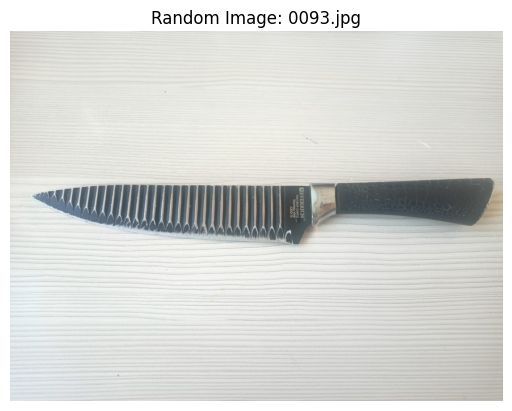

In [50]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Path to the images directory
images_directory = '/kaggle/input/kitchenware-classification/images'

# Get a list of all image files in the directory
image_files = os.listdir(images_directory)

# Display 10 random images
for _ in range(10):
    # Get a random image file
    random_image_file = random.choice(image_files)

    # Load and display the image
    image_path = os.path.join(images_directory, random_image_file)
    image = Image.open(image_path)

    # Display the image
    plt.imshow(image)
    plt.title(f'Random Image: {random_image_file}')
    plt.axis('off')
    plt.show()

In [5]:
import pandas as pd

# Path to the CSV file containing image labels
csv_path = '/kaggle/input/kitchenware-classification/train.csv'

# Read the CSV file into a DataFrame
df_train_full = pd.read_csv(csv_path, dtype={'Id': str})

# Assuming 'Id' is a column in your CSV file, and you have a directory 'images'
df_train_full['filename'] = '/kaggle/input/kitchenware-classification/images/' + df_train_full['Id'] + '.jpg'

# Display the first few rows of the DataFrame
df_train_full.head()

,Id,label,filename
0,0560,glass,/kaggle/input/kitchenware-classification/image...
1,4675,cup,/kaggle/input/kitchenware-classification/image...
2,0875,glass,/kaggle/input/kitchenware-classification/image...
3,4436,spoon,/kaggle/input/kitchenware-classification/image...
4,8265,plate,/kaggle/input/kitchenware-classification/image...


In [6]:
from sklearn.model_selection import train_test_split
# Split the DataFrame into training and validation sets
train_df, val_df = train_test_split(df_train_full, test_size=0.2, random_state=42)
print("train_df shape:", train_df.shape)
print("validation_df shape:", val_df.shape)

train_df shape: (4447, 3)
validation_df shape: (1112, 3)


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size and batch size
img_size = (224, 224)  # Adjust based on your model requirements
batch_size = 32

# Create ImageDataGenerators for training and validation
# With data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.4,
    zoom_range=0.4,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Flow images from directories and apply data augmentation
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='label',          # Assuming 'label' is the target variable
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',  # Adjust based on your model requirements
    shuffle=True
)


val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for validation

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='label',          # Assuming 'label' is the target variable
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',  # Adjust based on your model requirements
    shuffle=False  # No need to shuffle for validation
)

Found 4447 validated image filenames belonging to 6 classes.
Found 1112 validated image filenames belonging to 6 classes.


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import Xception

from tensorflow import keras

# Define the base model with pre-trained weights
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Create a Sequential model and add the Xception base model
model = Sequential()
model.add(base_model)

# Add additional layers on top of the Xception base model
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Add dropout for regularization

# Add more dense layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))  # Adjust dropout rate if needed

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))  # Adjust dropout rate if needed

# Output layer
model.add(Dense(6))  # Adjust the number of output classes based on your task

83683744/83683744 [==============================] - 0s 0us/step


In [12]:
# Compile the model
learning_rate = 0.001
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

# Define callbacks
checkpoint = ModelCheckpoint("best_model_xception.h5", monitor="val_accuracy", save_best_only=True)
early_stopping = EarlyStopping(monitor="val_loss", patience=5)

def lr_schedule(epoch):
    lr = 0.001
    if epoch > 10:
        lr *= 0.1  # Adjust timing of learning rate adjustment
    return lr
lr_scheduler = LearningRateScheduler(lr_schedule)

epochs = 20  # Increase the number of epochs for better convergence

# Fit the model with callbacks
history_xception = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[checkpoint, early_stopping, lr_scheduler]
)

Epoch 1/20
139/139 [==============================] - ETA: 0s - loss: 2.4207 - accuracy: 0.5662

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


139/139 [==============================] - 130s 848ms/step - loss: 2.4207 - accuracy: 0.5662 - val_loss: 0.3065 - val_accuracy: 0.8957 - lr: 0.0010
Epoch 2/20
139/139 [==============================] - 79s 571ms/step - loss: 0.8944 - accuracy: 0.6856 - val_loss: 0.2843 - val_accuracy: 0.8975 - lr: 0.0010
Epoch 3/20
139/139 [==============================] - 78s 563ms/step - loss: 0.8292 - accuracy: 0.7200 - val_loss: 0.2808 - val_accuracy: 0.8921 - lr: 0.0010
Epoch 4/20
139/139 [==============================] - 80s 573ms/step - loss: 0.7680 - accuracy: 0.7475 - val_loss: 0.2609 - val_accuracy: 0.9155 - lr: 0.0010
Epoch 5/20
139/139 [==============================] - 80s 572ms/step - loss: 0.7051 - accuracy: 0.7628 - val_loss: 0.2644 - val_accuracy: 0.9173 - lr: 0.0010
Epoch 6/20
139/139 [==============================] - 78s 560ms/step - loss: 0.6306 - accuracy: 0.7895 - val_loss: 0.2416 - val_accuracy: 0.9065 - lr: 0.0010
Epoch 7/20
139/139 [==============================] - 78s 560m

Visualizations are crucial for understanding model's performance. 

### 1. **Learning Curves:**
   - Plot the training and validation accuracy/loss over epochs to understand how well your model is learning.

In [12]:
import matplotlib.pyplot as plt

def visualize_training(history):
    # Create a figure with two subplots (1 row, 2 columns)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot training & validation accuracy values
    axes[0].plot(history.history['accuracy'])
    axes[0].plot(history.history['val_accuracy'])
    axes[0].set_title('Model accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    axes[1].set_title('Model loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend(['Train', 'Validation'], loc='upper left')

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()
    
    # Show the plots
    plt.show()


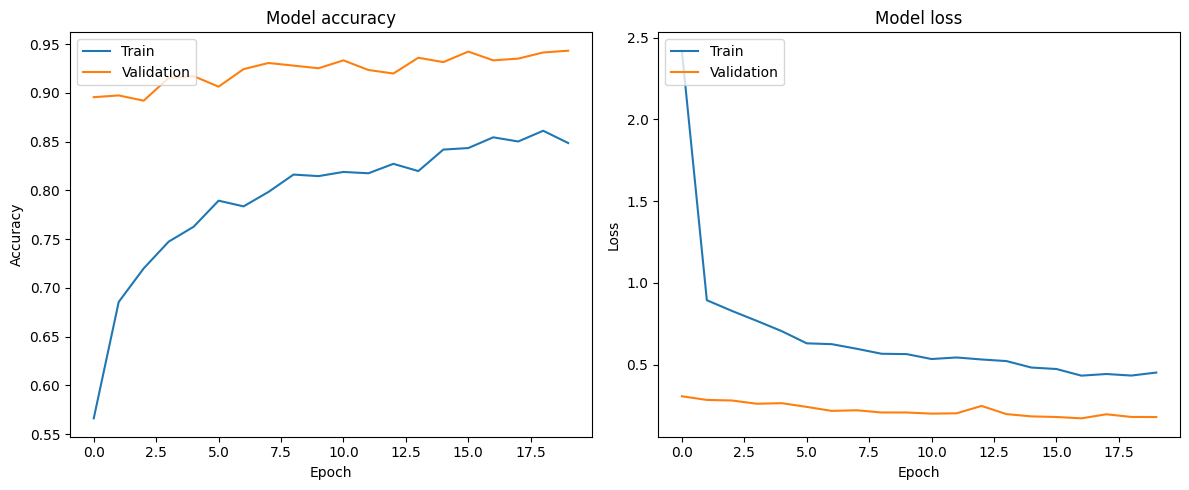

In [19]:
visualize_training(history_xception)

In [15]:
# Save the model in the native Keras format
model.save('best_model_xception.keras')

In [28]:
!ls

best_model.h5  best_model_xception.keras


In [4]:
!pip install numpy==1.22.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 55.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.7 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 11.0.0 which is incompatible.
chex 0.1.85 requires numpy>=1.24.1, but you have numpy 1.22.3 which is incompatible.
cudf 23.8.0 requires pandas<1.6.0dev0,>=1.3, but you have pandas 2.0.3 which is incompatible

In [5]:
from tensorflow import keras

# Load the model
xception_model = keras.models.load_model('best_model_xception.keras')

### 2. **Confusion Matrix:**
   - Visualize the confusion matrix to understand how well your model is classifying each class.

### 3. **Class-wise Accuracy:**
   - Plot the accuracy for each class to identify if there are specific classes where the model is struggling.

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

classes = np.array(['cup', 'fork', 'glass', 'knife', 'plate', 'spoon'])

def evaluate_model(model, val_generator):
    # Predict the classes for the validation set
    y_pred = model.predict(val_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Get the true classes
    y_true = val_generator.classes

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)

    # Create class-wise accuracy
    class_accuracy = cm.diagonal() / cm.sum(axis=1)

    # Create a figure with two subplots (1 row, 2 columns)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, ax=axes[0])
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')

    # Plot class-wise accuracy
    axes[1].bar(classes, class_accuracy)
    axes[1].set_title('Class-wise Accuracy')
    axes[1].set_xlabel('Class')
    axes[1].set_ylabel('Accuracy')

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()
    # Show the plots
    plt.show()

35/35 [==============================] - 7s 192ms/step


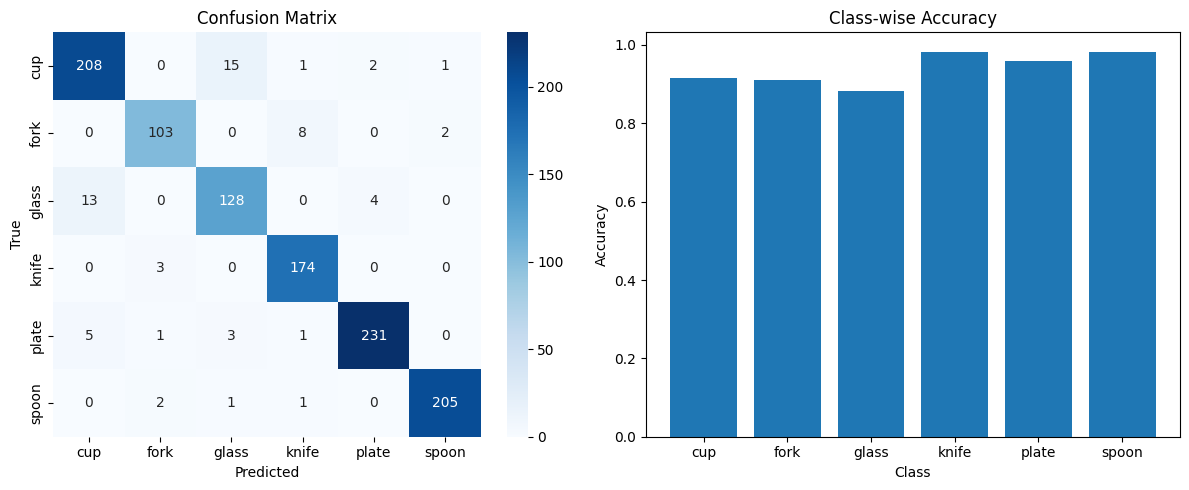

In [27]:
evaluate_model(xception_model, val_generator)

In [25]:
import pandas as pd

df_test = pd.read_csv('/kaggle/input/kitchenware-classification/test.csv', dtype={'Id': str})
df_test['filename'] = '/kaggle/input/kitchenware-classification/images/' + df_test['Id'] + '.jpg'
df_test.head()

,Id,filename
0,0678,/kaggle/input/kitchenware-classification/image...
1,3962,/kaggle/input/kitchenware-classification/image...
2,9271,/kaggle/input/kitchenware-classification/image...
3,5133,/kaggle/input/kitchenware-classification/image...
4,8842,/kaggle/input/kitchenware-classification/image...


In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input

img_size = (224, 224)
batch_size=32
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_dataframe(
    df_test,
    x_col='filename',
    class_mode=None,  # Set to None since it's a test dataset
    target_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

Found 3808 validated image filenames.


In [31]:
# Use the loaded model for prediction
y_pred = xception_model.predict(test_generator, verbose=1)
y_pred

119/119 [==============================] - 49s 407ms/step


array([[ 6.94749206e-02,  4.30114937e+00, -1.83996186e-02,
         5.87682724e+00,  3.82657975e-01,  3.98869944e+00],
       [ 6.23416543e-01,  4.39744997e+00,  3.14346850e-01,
         6.04756594e+00,  1.09638071e+00,  3.37941360e+00],
       [-5.60917616e+00,  1.45442705e+01,  1.52963877e+00,
         5.36430502e+00, -2.13327241e+00,  5.78296995e+00],
       ...,
       [-8.37330759e-01,  1.34029322e+01, -4.61065978e-01,
         5.36375141e+00, -1.73679996e+00,  1.84283524e+01],
       [-4.27822399e+00,  1.16495657e+01,  1.78675532e+00,
         4.17987633e+00, -1.12898421e+00,  4.80579281e+00],
       [-3.07163453e+00,  1.74952755e+01, -2.17291188e+00,
         5.36355495e+00, -3.74231172e+00,  2.49668865e+01]], dtype=float32)

In [32]:
y_pred.argmax(axis=1)

array([3, 3, 1, ..., 5, 1, 5])

In [34]:
predictions = classes[y_pred.argmax(axis=1)]
predictions

array(['knife', 'knife', 'fork', ..., 'spoon', 'fork', 'spoon'],
      dtype='<U5')

In [21]:
import numpy as np

classes = np.array(['cup', 'fork', 'glass', 'knife', 'plate', 'spoon'])

def predict_labels(model, test_generator):
    # Use the trained model for prediction
    y_pred = model.predict(test_generator, verbose=1)
    predictions = classes[y_pred.argmax(axis=1)]

    # Create a DataFrame for submission
    df_submission = pd.DataFrame()
    df_submission['filename'] = test_generator.filenames
    df_submission['label'] = predictions
    df_submission['Id'] = df_submission.filename.str[len('/kaggle/input/kitchenware-classification/images/'):-4].astype('int32')
    del df_submission['filename']

    return df_submission

In [15]:
# Predict labels
xception_predictions_df = predict_labels(xception_model, test_generator)
xception_predictions_df.head()

119/119 [==============================] - 28s 199ms/step


,label,Id
0,knife,678
1,knife,3962
2,fork,9271
3,plate,5133
4,fork,8842


In [32]:
!echo '{"username":"isaacndirangumuturi","key":"adcaa9e99c1a2e3b753754e4033af00b"}' > ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [33]:
import kaggle.api

def submit_to_kaggle(submission_df, competition_id, submission_filename):
    # Save the submission file
    submission_path = f'submission_{submission_filename}.csv'
    submission_df[['Id', 'label']].to_csv(submission_path, index=False)
    print(submission_df.head())

    # Submit to Kaggle
    kaggle.api.competition_submit(submission_path, f"Submission with '{submission_filename}' model", competition_id)

In [34]:
# Submit to Kaggle
submit_to_kaggle(xception_predictions_df, "kitchenware-classification", "xception")

   label    Id
0  knife   678
1  knife  3962
2   fork  9271
3  plate  5133
4   fork  8842


100%|██████████| 38.5k/38.5k [00:00<00:00, 55.1kB/s]


In [37]:
!ls

best_model.h5  best_model_xception.keras  submission_xception.csv


# MODEL 2

In [9]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import ResNet50

# Define the base model with pre-trained weights (ResNet50 in this case)
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_resnet.trainable = False

# Create a Sequential model and add the ResNet50 base model
model_resnet = Sequential()
model_resnet.add(base_model_resnet)

# Add additional layers on top of the ResNet50 base model
model_resnet.add(Flatten())
model_resnet.add(Dense(256, activation='relu'))
model_resnet.add(Dropout(0.5))

# Add more dense layers
model_resnet.add(Dense(128, activation='relu'))
model_resnet.add(Dropout(0.3))

model_resnet.add(Dense(64, activation='relu'))
model_resnet.add(Dropout(0.2))

# Output layer
model_resnet.add(Dense(6))  # Adjust the number of output classes 

# Compile the model
learning_rate_resnet = 0.001
optimizer_resnet = keras.optimizers.Adam(learning_rate=learning_rate_resnet)
loss_resnet = keras.losses.CategoricalCrossentropy(from_logits=True)
model_resnet.compile(optimizer=optimizer_resnet, loss=loss_resnet, metrics=['accuracy'])

# Display the model summary
model_resnet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_8 (Dense)             (None, 256)               25690368  
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)               

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

def lr_schedule(epoch):
    lr = 0.001
    if epoch > 10:
        lr *= 0.1  # Adjust timing of learning rate adjustment
    return lr
lr_scheduler = LearningRateScheduler(lr_schedule)

epochs = 10  # Increase the number of epochs for better convergence

# Define callbacks for training
checkpoint_resnet = ModelCheckpoint("best_model_resnet.h5", monitor="val_accuracy", save_best_only=True)
early_stopping_resnet = EarlyStopping(monitor="val_loss", patience=5)
lr_scheduler_resnet = LearningRateScheduler(lr_schedule)


# Fit the model with callbacks
history_resnet = model_resnet.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[checkpoint_resnet, early_stopping_resnet, lr_scheduler_resnet]
)


Epoch 1/10
139/139 [==============================] - ETA: 0s - loss: 2.2308 - accuracy: 0.2087

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


139/139 [==============================] - 115s 734ms/step - loss: 2.2308 - accuracy: 0.2087 - val_loss: 1.7676 - val_accuracy: 0.2167 - lr: 0.0010
Epoch 2/10
139/139 [==============================] - 78s 558ms/step - loss: 1.7708 - accuracy: 0.2183 - val_loss: 1.7621 - val_accuracy: 0.2167 - lr: 0.0010
Epoch 3/10
139/139 [==============================] - 77s 555ms/step - loss: 1.7625 - accuracy: 0.2206 - val_loss: 1.7614 - val_accuracy: 0.2167 - lr: 0.0010
Epoch 4/10
139/139 [==============================] - 79s 568ms/step - loss: 1.7740 - accuracy: 0.2215 - val_loss: 1.7609 - val_accuracy: 0.2167 - lr: 0.0010
Epoch 5/10
139/139 [==============================] - 78s 564ms/step - loss: 1.7623 - accuracy: 0.2183 - val_loss: 1.7609 - val_accuracy: 0.2167 - lr: 0.0010
Epoch 6/10
139/139 [==============================] - 77s 554ms/step - loss: 1.7628 - accuracy: 0.2228 - val_loss: 1.7611 - val_accuracy: 0.2167 - lr: 0.0010
Epoch 7/10
139/139 [==============================] - 78s 558m

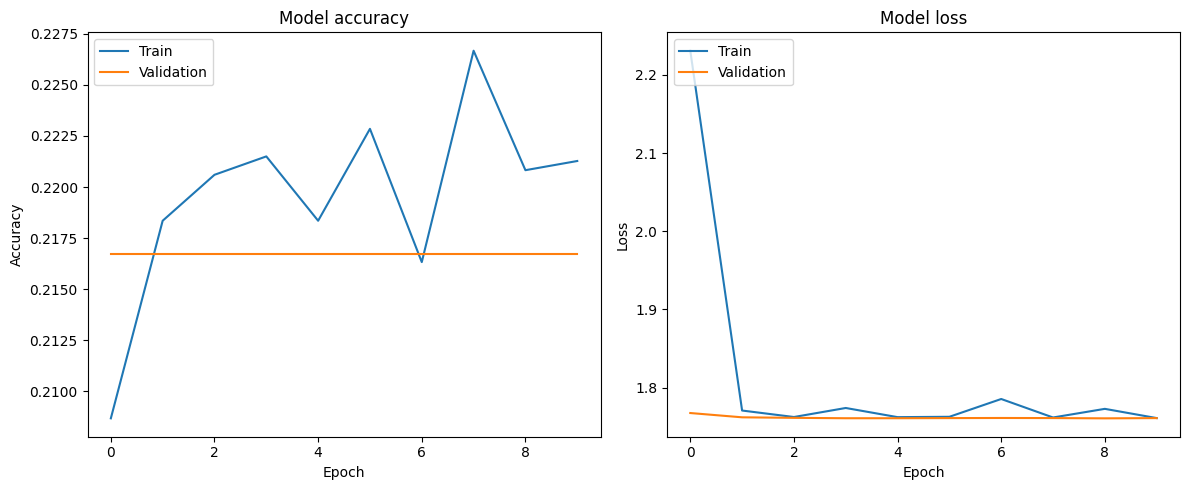

In [13]:
visualize_training(history_resnet)

In [15]:
# Save the model in the native Keras format
model_resnet.save('best_model_resnet.keras')

In [16]:
from tensorflow import keras

# Load the model
resnet_model = keras.models.load_model('best_model_resnet.keras')

35/35 [==============================] - 8s 208ms/step


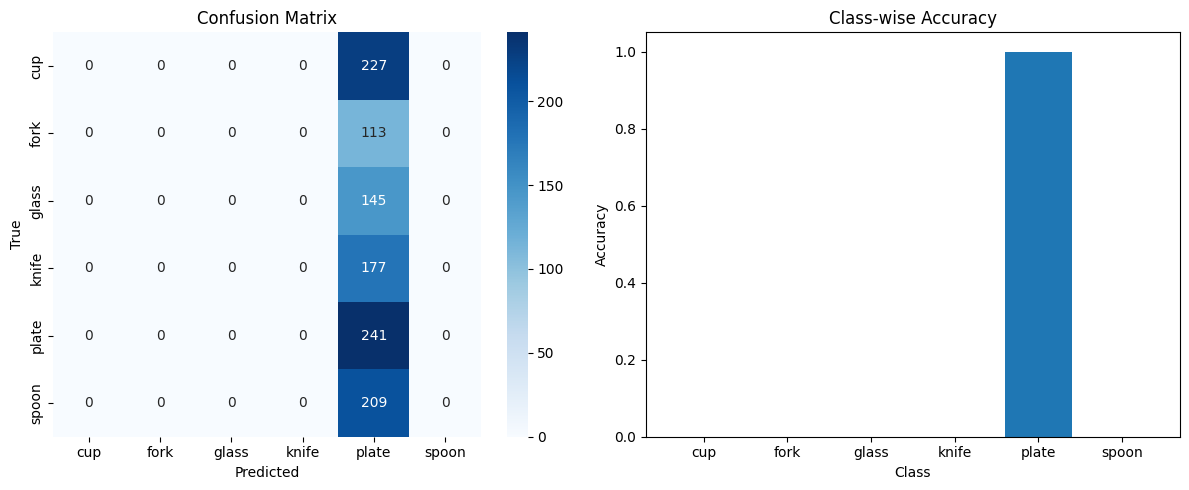

In [19]:
evaluate_model(resnet_model, val_generator)

In [27]:
# Predict labels
resnet_predictions_df = predict_labels(resnet_model, test_generator)
resnet_predictions_df.head()

119/119 [==============================] - 39s 322ms/step


,label,Id
0,plate,678
1,plate,3962
2,plate,9271
3,plate,5133
4,plate,8842


In [34]:
# Submit to Kaggle
submit_to_kaggle(resnet_predictions_df, "kitchenware-classification", "resnet")

   label    Id
0  plate   678
1  plate  3962
2  plate  9271
3  plate  5133
4  plate  8842


100%|██████████| 40.5k/40.5k [00:01<00:00, 26.3kB/s]


In [ ]:
!ls

In [ ]:
import tensorflow as tf

# Load the Keras model
model = tf.keras.models.load_model('kitchenware_model.h5')

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('kitchenware_model.tflite', 'wb') as f:
    f.write(tflite_model)


In [ ]:
import lambda_function

lambda_function.predict("https://www.pngall.com/wp-content/uploads/4/Cup-PNG-Image-File.png")

Follow me on Twitter 🐦, connect with me on LinkedIn 🔗, and check out my GitHub 🐙. You won't be disappointed!

👉 Twitter: https://twitter.com/NdiranguMuturi1  
👉 LinkedIn: https://www.linkedin.com/in/isaac-muturi-3b6b2b237  
👉 GitHub: https://github.com/Isaac-Ndirangu-Muturi-749